# Training with Back-propagation Algorithms

Back-propagation (BP) trainings have become foundations in machine learning algorithms. In this section, we are going to talk about how to train models with BP.

In [1]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd
import numpy as np

bm.set_mode(bm.training_mode)
bm.set_platform('cpu')

bp.__version__

'2.4.0'

Here, we train two kinds of models to classify MNIST dataset. The first is ANN models commonly used in deep neural networks. The second is SNN models.

## Train a ANN model

We first build a three layer ANN model:

```bash

i >> r >> o
```

where the recurrent layer ``r`` is a LSTM cell, the output ``o`` is a linear readout.

In [2]:
class ANNModel(bp.DynamicalSystem):
    def __init__(self, num_in, num_rec, num_out):
        super(ANNModel, self).__init__()
        self.rec = bp.layers.LSTMCell(num_in, num_rec)
        self.out = bp.layers.Dense(num_rec, num_out)

    def update(self, x):
        return x >> self.rec >> self.out

Before training this model, we get and clean the data we want.

In [3]:
root = r"D:\data"
train_dataset = bd.vision.FashionMNIST(root, split='train', download=True)
test_dataset = bd.vision.FashionMNIST(root, split='test', download=True)


def get_data(dataset, batch_size=256):
  rng = bm.random.default_rng()

  def data_generator():
    X = bm.array(dataset.data, dtype=bm.float_) / 255
    Y = bm.array(dataset.targets, dtype=bm.float_)
    key = rng.split_key()
    rng.shuffle(X, key=key)
    rng.shuffle(Y, key=key)
    for i in range(0, len(dataset), batch_size):
      yield X[i: i + batch_size], Y[i: i + batch_size]

  return data_generator

Then, we start to train our defined ANN model with ``brainpy.train.BPTT`` training interface.

In [4]:
# model
model = ANNModel(28, 100, 10)

# loss function
def loss_fun(predicts, targets):
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(axis=-1) == targets)
    return loss, {'acc': acc}

# optimizer
optimizer=bp.optim.Adam(lr=1e-3)

# trainer
trainer = bp.BPTT(model,
                 loss_fun=loss_fun,
                 loss_has_aux=True,
                 optimizer=optimizer)

In [5]:
trainer.fit(train_data=get_data(train_dataset, 256),
            test_data=get_data(test_dataset, 512),
            num_epoch=10)

Train 0 epoch, use 15.9655 s, loss 0.8331242203712463, acc 0.7072529196739197
Test 0 epoch, use 1.5463 s, loss 0.5571460127830505, acc 0.7961569428443909
Train 1 epoch, use 9.1526 s, loss 0.5049400925636292, acc 0.8177083730697632
Test 1 epoch, use 0.3750 s, loss 0.502030074596405, acc 0.81787109375
Train 2 epoch, use 9.2934 s, loss 0.46436846256256104, acc 0.8321365714073181
Test 2 epoch, use 0.3476 s, loss 0.48068222403526306, acc 0.8233513236045837
Train 3 epoch, use 9.0547 s, loss 0.4441152811050415, acc 0.8387909531593323
Test 3 epoch, use 0.3461 s, loss 0.4624057412147522, acc 0.8308019638061523
Train 4 epoch, use 9.2218 s, loss 0.42878103256225586, acc 0.8456172943115234
Test 4 epoch, use 0.3652 s, loss 0.45214834809303284, acc 0.835742175579071
Train 5 epoch, use 9.7000 s, loss 0.4177688956260681, acc 0.848858654499054
Test 5 epoch, use 0.3666 s, loss 0.45152249932289124, acc 0.8364028334617615
Train 6 epoch, use 9.5577 s, loss 0.4085409343242645, acc 0.8526595830917358
Test 6 

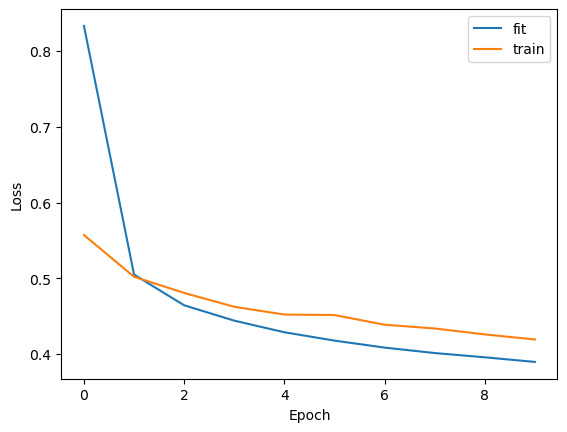

In [6]:
import matplotlib.pyplot as plt

plt.plot(trainer.get_hist_metric('fit'), label='fit')
plt.plot(trainer.get_hist_metric('test'), label='train')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train a SNN model

Similarly, ``brainpy.train.BPTT`` can also be used to train SNN models.

We first build a three layer SNN model:

```bash

i >> [exponential synapse] >> r >> [exponential synapse] >> o
```

In [7]:
class SNNModel(bp.DynamicalSystem):
  def __init__(self, num_in, num_rec, num_out):
    super(SNNModel, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out

    # neuron groups
    self.i = bp.neurons.InputGroup(num_in)
    self.r = bp.neurons.LIF(num_rec, tau=10, V_reset=0, V_rest=0, V_th=1.)
    self.o = bp.neurons.LeakyIntegrator(num_out, tau=5)

    # synapse: i->r
    self.i2r = bp.synapses.Exponential(self.i, self.r, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(),
                                       tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.))
    # synapse: r->o
    self.r2o = bp.synapses.Exponential(self.r, self.o, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(),
                                       tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.))

  def update(self, spike):
    self.i2r(spike)
    self.r2o()
    self.r()
    self.o()
    return self.o.V.value

As the model receives spiking inputs, we define functions that are necessary to transform the continuous values to spiking data.

In [8]:
def current2firing_time(x, tau=20., thr=0.2, tmax=1.0, epsilon=1e-7):
  x = np.clip(x, thr + epsilon, 1e9)
  T = tau * np.log(x / (x - thr))
  T = np.where(x < thr, tmax, T)
  return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
  labels_ = np.array(y, dtype=bm.int_)
  sample_index = np.arange(len(X))

  # compute discrete firing times
  tau_eff = 2. / bm.get_dt()
  unit_numbers = np.arange(nb_units)
  firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=bm.int_)

  if shuffle:
    np.random.shuffle(sample_index)

  counter = 0
  number_of_batches = len(X) // batch_size
  while counter < number_of_batches:
    batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
    all_batch, all_times, all_units = [], [], []
    for bc, idx in enumerate(batch_index):
      c = firing_times[idx] < nb_steps
      times, units = firing_times[idx][c], unit_numbers[c]
      batch = bc * np.ones(len(times), dtype=bm.int_)
      all_batch.append(batch)
      all_times.append(times)
      all_units.append(units)
    all_batch = np.concatenate(all_batch).flatten()
    all_times = np.concatenate(all_times).flatten()
    all_units = np.concatenate(all_units).flatten()
    x_batch = bm.zeros((batch_size, nb_steps, nb_units))
    x_batch[all_batch, all_times, all_units] = 1.
    y_batch = bm.asarray(labels_[batch_index])
    yield x_batch, y_batch
    counter += 1

Now, we can define a BP trainer for this SNN model.

In [9]:
def loss_fun(predicts, targets):
    predicts, mon = predicts
    # L1 loss on total number of spikes
    l1_loss = 1e-5 * bm.sum(mon['r.spike'])
    # L2 loss on spikes per neuron
    l2_loss = 1e-5 * bm.mean(bm.sum(bm.sum(mon['r.spike'], axis=0), axis=0) ** 2)
    # predictions
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(-1) == targets)
    return loss + l2_loss + l1_loss, {'acc': acc}

model = SNNModel(num_in=28*28, num_rec=100, num_out=10)

trainer = bp.BPTT(
    model,
    loss_fun=loss_fun,
    loss_has_aux=True,
    optimizer=bp.optim.Adam(lr=1e-3),
    monitors={'r.spike': model.r.spike},
)

The training process is similar to that of the ANN model, instead of the data is generated by the sparse generator function we defined above.

In [10]:
x_train = bm.array(train_dataset.data, dtype=bm.float_) / 255
y_train = bm.array(train_dataset.targets, dtype=bm.int_)

trainer.fit(lambda: sparse_data_generator(x_train.reshape(x_train.shape[0], -1),
                                          y_train,
                                          batch_size=256,
                                          nb_steps=100,
                                          nb_units=28 * 28),
            num_epoch=10)

Train 0 epoch, use 49.9356 s, loss 13.577051162719727, acc 0.3795405924320221
Train 1 epoch, use 53.5827 s, loss 1.9439359903335571, acc 0.5677751302719116
Train 2 epoch, use 50.4796 s, loss 1.6432150602340698, acc 0.5903278589248657
Train 3 epoch, use 52.2995 s, loss 1.4753005504608154, acc 0.6055355072021484
Train 4 epoch, use 54.8472 s, loss 1.3759807348251343, acc 0.6247329115867615
Train 5 epoch, use 59.3077 s, loss 1.3128257989883423, acc 0.6393396258354187
Train 6 epoch, use 54.3296 s, loss 1.2489423751831055, acc 0.6562833786010742
Train 7 epoch, use 53.8313 s, loss 1.2068374156951904, acc 0.6707565188407898
Train 8 epoch, use 58.7923 s, loss 1.163095474243164, acc 0.6782184839248657
Train 9 epoch, use 56.4727 s, loss 1.1365898847579956, acc 0.6831930875778198


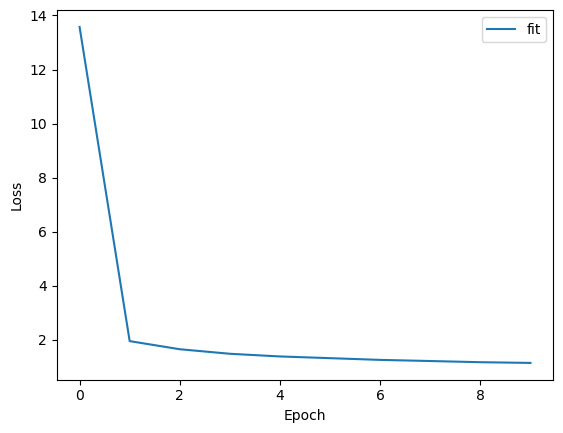

In [11]:
plt.plot(trainer.get_hist_metric('fit'), label='fit')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Customize your BP training

Actually, ``brainpy.train.BPTT`` is just one way to perform back-propagation training with your model. You can easily customize your training process.

In the below, we demonstrate how to define a BP training process by hand with the above ANN model.

In [12]:
# packages we need

from time import time

In [13]:
# define the model
model = ANNModel(28, 100, 10)

In [14]:
# define the loss function
def loss_fun(inputs, targets):
  runner = bp.DSTrainer(model, progress_bar=False, numpy_mon_after_run=False)
  predicts = runner.predict(inputs, reset_state=True)
  predicts = bm.max(predicts, axis=1)
  loss = bp.losses.cross_entropy_loss(predicts, targets)
  acc = bm.mean(predicts.argmax(-1) == targets)
  return loss, acc

In [15]:
# define the gradient function which computes the
# gradients of the trainable weights
grad_fun = bm.grad(loss_fun,
                   grad_vars=model.train_vars().unique(),
                   has_aux=True,
                   return_value=True)

In [16]:
# define the optimizer we need
opt = bp.optim.Adam(lr=1e-3, train_vars=model.train_vars().unique())

In [17]:
# training function

@bm.jit
def train(xs, ys):
  grads, loss, acc = grad_fun(xs, ys)
  opt.update(grads)
  return loss, acc

In [18]:
# start training

k = 0
num_batch = 256
running_loss = 0
running_acc = 0
print_step = 100
X_train = bm.asarray(x_train)
Y_train = bm.asarray(y_train)
t0 = time()
for _ in range(10):  # number of epoch
  X_train = bm.random.permutation(X_train, key=123)
  Y_train = bm.random.permutation(Y_train, key=123)

  for i in range(0, X_train.shape[0], num_batch):
    X = X_train[i: i + num_batch]
    Y = Y_train[i: i + num_batch]
    loss_, acc_ = train(X, Y)
    running_loss += loss_
    running_acc += acc_
    k += 1
    if k % print_step == 0:
      print('Step {}, Used {:.4f} s, Loss {:0.4f}, Acc {:0.4f}'.format(
        k, time() - t0,  running_loss / print_step, running_acc / print_step)
      )
      t0 = time()
      running_loss = 0
      running_acc = 0

Step 100, Used 10.7392 s, Loss 0.9717, Acc 0.6601
Step 200, Used 8.6341 s, Loss 0.5624, Acc 0.7991
Step 300, Used 7.8616 s, Loss 0.5135, Acc 0.8158
Step 400, Used 5.1792 s, Loss 0.4775, Acc 0.8266
Step 500, Used 5.1241 s, Loss 0.4563, Acc 0.8346
Step 600, Used 5.5137 s, Loss 0.4494, Acc 0.8342
Step 700, Used 5.1346 s, Loss 0.4356, Acc 0.8417
Step 800, Used 5.2631 s, Loss 0.4338, Acc 0.8414
Step 900, Used 5.3202 s, Loss 0.4043, Acc 0.8520
Step 1000, Used 5.2687 s, Loss 0.4055, Acc 0.8528
Step 1100, Used 5.9954 s, Loss 0.4005, Acc 0.8543
Step 1200, Used 5.9213 s, Loss 0.3982, Acc 0.8542
Step 1300, Used 6.0832 s, Loss 0.3845, Acc 0.8595
Step 1400, Used 5.5973 s, Loss 0.3902, Acc 0.8575
Step 1500, Used 5.5119 s, Loss 0.3781, Acc 0.8624
Step 1600, Used 5.4341 s, Loss 0.3743, Acc 0.8632
Step 1700, Used 5.5067 s, Loss 0.3764, Acc 0.8626
Step 1800, Used 5.6223 s, Loss 0.3689, Acc 0.8645
Step 1900, Used 5.4748 s, Loss 0.3648, Acc 0.8672
Step 2000, Used 5.2963 s, Loss 0.3683, Acc 0.8674
Step 210